In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import arviz as az

In [2]:
SEEDS = 500

In [3]:
def population_dist(z):
    alpha_population = 5
    return st.invgamma.pdf(z, alpha_population, scale=2, loc=1)

def merger_rate(z):
    alpha_merger_rate = 8
    return st.invgamma.pdf(z, alpha_merger_rate, scale=5, loc=1)

def detection_rate(z):
    return merger_rate(z) * .60


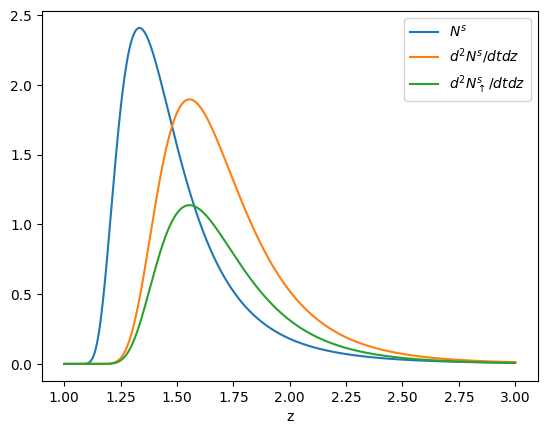

In [4]:
z = np.linspace(1, 3, 1000)
plt.plot(z, population_dist(z), label='$N^s$')
plt.plot(z, merger_rate(z), label='$d^2N^s/dtdz$')
plt.plot(z, detection_rate(z), label='$d^2N_\\uparrow^s/dtdz$')
plt.xlabel('z')
plt.legend()

In [5]:
from random import randrange
z_events = [np.random.uniform(0, 3) for _ in range(SEEDS)] # only natural numbers are generated

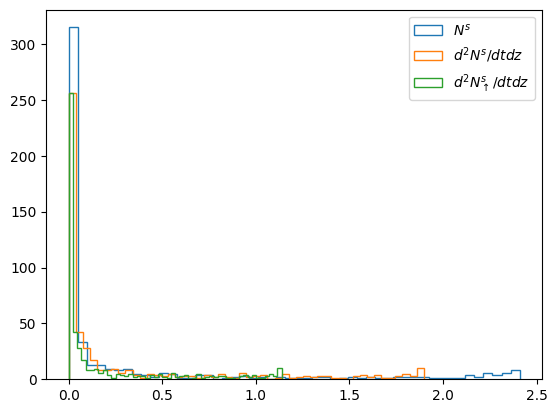

In [6]:
plt.hist(population_dist(z_events), bins=50, fill=False, histtype='step', label='$N^s$')
plt.hist(merger_rate(z_events), bins=50, fill=False, histtype='step', label='$d^2N^s/dtdz$')
plt.hist(detection_rate(z_events), bins=50, fill=False, histtype='step', label='$d^2N_\\uparrow^s/dtdz$')
plt.legend()

In [7]:
LEN_DATA = 500
X = np.empty((SEEDS, LEN_DATA))
for i in range(SEEDS):
    X[i] = st.norm(loc=detection_rate(z[i]), scale=0.5).rvs(size=LEN_DATA)

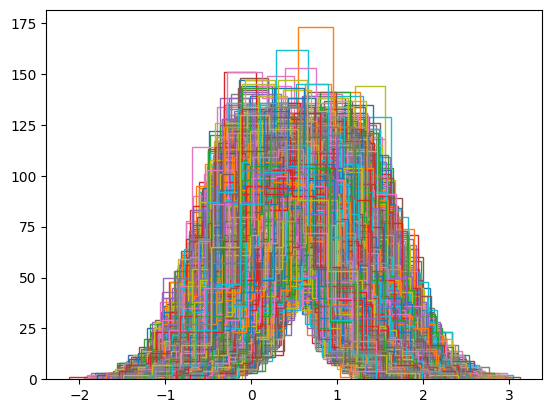

In [8]:
# large number of data sets can lead to a messy plot
for i in range(SEEDS):
    plt.hist(X[i], fill=False, histtype='step', label=i)
#plt.legend()

In [9]:
import pymc3 as pm

In [15]:
with pm.Model() as model:
    alpha_merger_rate = pm.Uniform('MR', lower=0, upper=10)
    MU = pm.Uniform('MU', lower=0, upper=10)
    SIGMA = pm.Uniform('SIGMA', lower=0, upper=10)
    hyperprior = pm.InverseGamma('LAMBDA', alpha=alpha_merger_rate, mu=MU, sigma=SIGMA) # hyperprior
    prior = pm.Normal('mu', mu=hyperprior, sigma=0.5)  # prior draws data points from hyperprior
    obs = pm.Normal('obs', mu=prior, sigma=1, observed=X)  # likelihood draws data points from prior
    step = pm.Metropolis()
 
    # sample with 3 independent Markov chains
    trace = pm.sample(draws=1000, chains=2, step=step, return_inferencedata=True)

Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [LAMBDA]
>Metropolis: [SIGMA]
>Metropolis: [MU]
>Metropolis: [MR]


/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 3 chains for 1_000 tune and 500 draw iterations (3_000 + 1_500 draws total) took 2 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [16]:
az.summary(trace, var_names=["MU", "SIGMA", "MR"])["mean"]

MU       5.345
SIGMA    4.947
MR       5.259
Name: mean, dtype: float64

array([[<Axes: title={'center': 'MU'}>, <Axes: title={'center': 'MU'}>],
       [<Axes: title={'center': 'SIGMA'}>,
        <Axes: title={'center': 'SIGMA'}>],
       [<Axes: title={'center': 'MR'}>, <Axes: title={'center': 'MR'}>]],
      dtype=object)

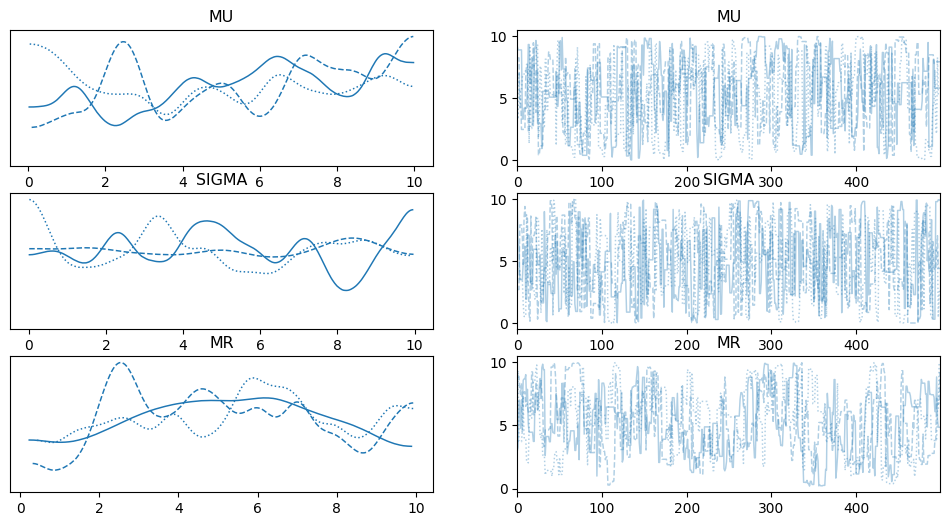

In [17]:
az.plot_trace(trace, var_names=("MU", "SIGMA", "MR"))

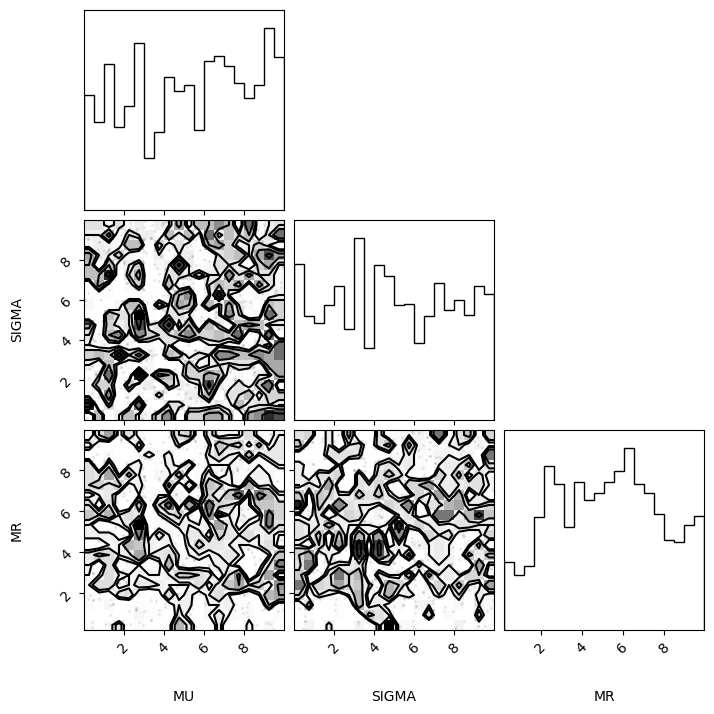

In [18]:
import corner
_ = corner.corner(trace, var_names=["MU", "SIGMA", "MR"])